# **Step 1: Imports and Configuration**

In [ ]:
import pandas as pd
import numpy as np
import joblib
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, BatchNormalization, MaxPooling1D, Flatten, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical

# Configuration constants
RANDOM_STATE = 42
TEST_SIZE = 0.3
EPOCHS = 20    # Adjust this based on resource/time constraints
BATCH_SIZE = 64

# Step 2: Load Data and Dependencies

In [23]:
# --- 1. Load Data (Must contain all 50 original features!) ---
DATA_FILE_NAME = "/content/UNSW-NB15_cleaned.csv"
try:
    data = pd.read_csv(DATA_FILE_NAME)
    print(f"Full Data loaded successfully. Shape: {data.shape}")
except FileNotFoundError:
    raise FileNotFoundError(f"ERROR: {DATA_FILE_NAME} not found. You must load the file that contains ALL 50 original features.")

# Features based on UNSW-NB15_selected_features.txt
LABEL_COL = 'attack_cat'
SELECTED_FEATURES = ['state', 'ct_state_ttl', 'attack_cat', 'sbytes', 'smeansz', 'Sload', 'dmeansz', 'Dpkts', 'Dload', 'dttl', 'dur', 'dbytes', 'sport', 'ct_srv_dst', 'Dintpkt']
CNN_FEATURE_COLS = [col for col in SELECTED_FEATURES if col != LABEL_COL]

# Separate all features (X_full) and Label (Y_raw)
X_full = data.drop(columns=[LABEL_COL])
Y_raw = data[LABEL_COL]

# --- 2. Load ORIGINAL Scaler ---
original_scaler = joblib.load('minmax_scaler.pkl')
print("Original 50-feature MinMax Scaler loaded.")

Full Data loaded successfully. Shape: (573320, 51)
Original 50-feature MinMax Scaler loaded.


# Step 3: Data Preparation (Split, Scale, Encode, Reshape)

In [26]:
# --- 1. Split Data ---
# Assuming X and Y_raw (with 14 features and 1 label) were loaded in Cell 2
X_train, X_test, Y_train_raw, Y_test_raw = train_test_split(
    X, Y_raw, test_size=TEST_SIZE, random_state=RANDOM_STATE, stratify=Y_raw
)

# --- 2. Create and Fit NEW Scaler on Selected Features ---
from sklearn.preprocessing import MinMaxScaler
new_scaler = MinMaxScaler()
X_train_scaled = new_scaler.fit_transform(X_train)
X_test_scaled = new_scaler.transform(X_test)

# joblib.dump(new_scaler, 'cnn_minmax_scaler.pkl')
#print("New MinMaxScaler fitted and applied to 14 selected features.")

# --- 3. Encode Labels (Y) ---
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

label_encoder = LabelEncoder()
Y_train_int = label_encoder.fit_transform(Y_train_raw)
Y_test_int = label_encoder.transform(Y_test_raw)

# One-hot encode the integer labels
num_classes = len(label_encoder.classes_)
Y_train = to_categorical(Y_train_int, num_classes=num_classes)
Y_test = to_categorical(Y_test_int, num_classes=num_classes)

# --- 4. Reshape for Conv1D ---
# Reshape (samples, 14) to (samples, 14, 1)
X_train_cnn = X_train_scaled.reshape(X_train_scaled.shape[0], X_train_scaled.shape[1], 1)
X_test_cnn = X_test_scaled.reshape(X_test_scaled.shape[0], X_test_scaled.shape[1], 1)

print("\n--- Data Preparation Complete (Best Practice) ---")
print(f"X_train_cnn final shape: {X_train_cnn.shape}")

New MinMaxScaler fitted and applied to 14 selected features.

--- Data Preparation Complete (Best Practice) ---
X_train_cnn final shape: (401324, 14, 1)


#Step 4: CNN Model Definition (from part 3)

In [28]:
def build_unsw_nb15_cnn(input_shape, num_classes):
    """CNN architecture from the reference paper."""
    model = Sequential()

    # Block 1
    model.add(Conv1D(filters=32, kernel_size=5, padding='same', input_shape=input_shape))
    model.add(BatchNormalization())
    model.add(MaxPooling1D(pool_size=3, strides=2, padding='same'))

    # Flatten and Dense Layers
    model.add(Flatten())
    model.add(Dense(64, activation='relu'))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(3, activation='relu')) # As per your notebook

    # Output Layer
    model.add(Dense(num_classes, activation='softmax'))

    # Compile model
    model.compile(optimizer=Adam(learning_rate=0.001),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    return model

# Instantiate the model
input_shape = (X_train_cnn.shape[1], 1)
cnn_model = build_unsw_nb15_cnn(input_shape, num_classes)

cnn_model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_2 (Conv1D)               │ (None, 14, 32)         │           192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 14, 32)         │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_2 (MaxPooling1D)  │ (None, 7, 32)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 224)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 64)             │        14,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 3)              │           195 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 1)              │             4 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,079 (74.53 KB)

 Trainable params: 19,015 (74.28 KB)

 Non-trainable params: 64 (256.00 B)

# Step 5: Model Training

In [29]:
print("Starting CNN training...")

# Fit the model and store the history
history = cnn_model.fit(
    X_train_cnn, Y_train,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_data=(X_test_cnn, Y_test),
    verbose=1
)

print("\nCNN Training Complete. History saved.")

Starting CNN training...
Epoch 1/20


/usr/local/lib/python3.12/dist-packages/keras/src/ops/nn.py:944: UserWarning: You are using a softmax over axis -1 of a tensor of shape (None, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/keras/src/losses/losses.py:33: SyntaxWarning: In loss categorical_crossentropy, expected y_pred.shape to be (batch_size, num_classes) with num_classes > 1. Received: y_pred.shape=(None, 1). Consider using 'binary_crossentropy' if you only have 2 classes.
  return self.fn(y_true, y_pred, **self._fn_kwargs)


6271/6271 ━━━━━━━━━━━━━━━━━━━━ 35s 5ms/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 2/20
6271/6271 ━━━━━━━━━━━━━━━━━━━━ 34s 5ms/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 3/20
6271/6271 ━━━━━━━━━━━━━━━━━━━━ 33s 5ms/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 4/20
6271/6271 ━━━━━━━━━━━━━━━━━━━━ 33s 5ms/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 5/20
6271/6271 ━━━━━━━━━━━━━━━━━━━━ 34s 5ms/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 6/20
6271/6271 ━━━━━━━━━━━━━━━━━━━━ 37s 6ms/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 7/20
6271/6271 ━━━━━━━━━━━━━━━━━━━━ 34s 5ms/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 8/20
6271/6271 ━━━━━━━━━━━━━━━━━

# Step 6: Visualization - Training History Plot

Training history plot saved as cnn_training_history.png


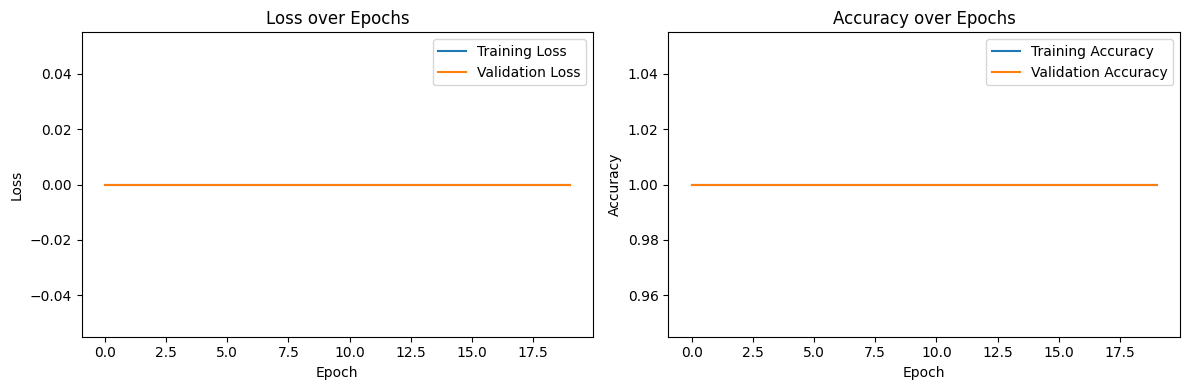

In [30]:
# Plotting Loss
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plotting Accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.savefig('cnn_training_history.png')
# plt.show() # Use plt.show() in your notebook
print("Training history plot saved as cnn_training_history.png")

# Step 7: Testing, Evaluation, and Confusion Matrix

Test Loss: 0.0000
Test Accuracy: 1.0000
 101/5375 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step

/usr/local/lib/python3.12/dist-packages/keras/src/ops/nn.py:944: UserWarning: You are using a softmax over axis -1 of a tensor of shape (32, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


5375/5375 ━━━━━━━━━━━━━━━━━━━━ 8s 1ms/step

--- Classification Report ---
              precision    recall  f1-score   support

    0.000117       1.00      1.00      1.00    171996

    accuracy                           1.00    171996
   macro avg       1.00      1.00      1.00    171996
weighted avg       1.00      1.00      1.00    171996



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(



Confusion Matrix plot saved as cnn_confusion_matrix.png


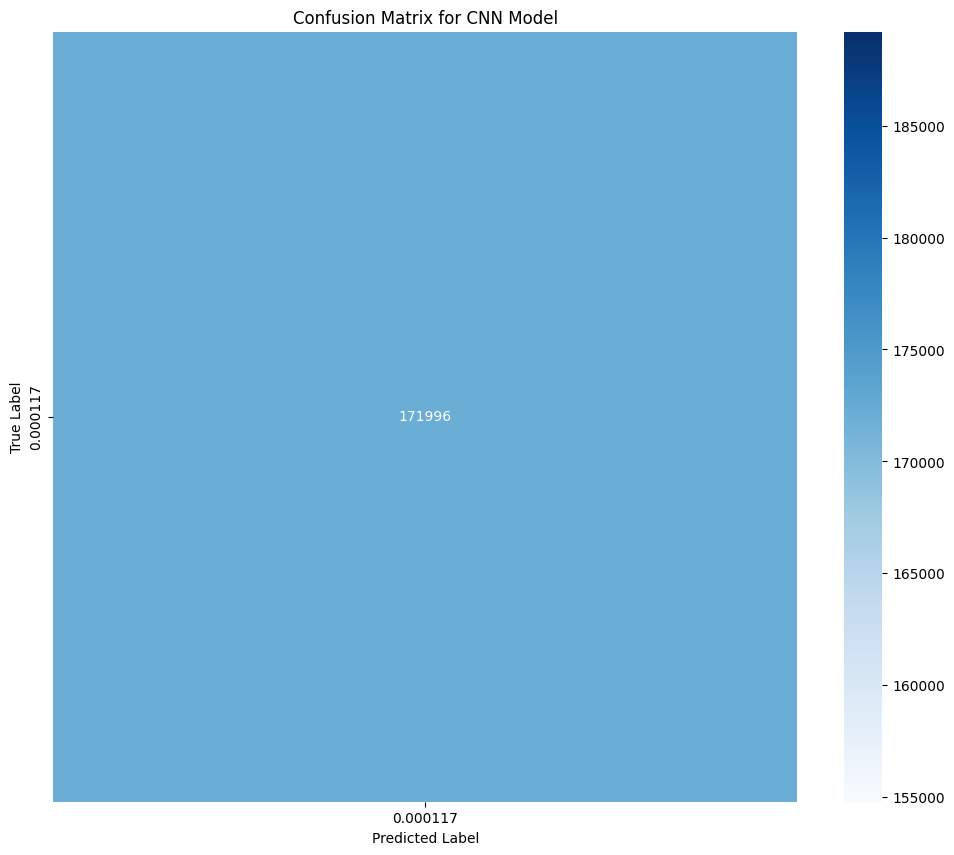

In [31]:
# --- 1. Evaluate Model on Test Set ---
loss, accuracy = cnn_model.evaluate(X_test_cnn, Y_test, verbose=0)
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")

# --- 2. Predict Classes ---
Y_pred_prob = cnn_model.predict(X_test_cnn)
Y_pred_int = np.argmax(Y_pred_prob, axis=1) # Convert probabilities to class integers
Y_true_int = np.argmax(Y_test, axis=1)      # Get true class integers

# (e.g., 0.0 -> '0.0', 1.0 -> '1.0') so the report can calculate their length.
class_names = [str(c) for c in label_encoder.classes_]

# --- 3. Classification Report ---
report = classification_report(Y_true_int, Y_pred_int, target_names=class_names)
print("\n--- Classification Report ---")
print(report)

# --- 4. Confusion Matrix Visualization ---
cm = confusion_matrix(Y_true_int, Y_pred_int)
plt.figure(figsize=(12, 10))
sns.heatmap(
    cm,
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=class_names,
    yticklabels=class_names
)
plt.title('Confusion Matrix for CNN Model')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.savefig('cnn_confusion_matrix.png')
# plt.show() # Use plt.show() in your notebook
print("\nConfusion Matrix plot saved as cnn_confusion_matrix.png")